In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Results - Classification

> Use fingerprints to classify 50k reaction data set by Schneider et al.. This notebook is based on the notebooks and code found in the SI of [Development of a Novel Fingerprint for Chemical Reactions and Its Application to Large-Scale Reaction Classification and Similarity](https://pubs.acs.org/doi/10.1021/ci5006614)

In [ ]:
#hide
import json
import copy
import random
import pandas as pd
import numpy as np
from sklearn import metrics
import random
from sklearn.linear_model import LogisticRegression

In [ ]:
#hide
def evaluate_model(model, fingerprints, corresponding_classes, all_classes, all_classes_names):
    
    preds = model.predict(fingerprints)
    predicted_classes = [all_classes[x] for x in preds]
    expected_classes =[all_classes[x] for x in corresponding_classes]

    confusion_matrix = metrics.confusion_matrix(corresponding_classes, preds)
    colCounts = confusion_matrix.sum(axis=0)
    rowCounts = confusion_matrix.sum(axis=1)

    print(' & recall & prec & F-score  &   reaction class &  \\\\ ')
    sum_recall=0
    sum_prec=0
    for i, rxn_class in enumerate(all_classes):
        recall = 0
        if rowCounts[i] > 0:
            recall = float(confusion_matrix[i,i])/rowCounts[i]
        sum_recall += recall
        prec = 0
        if colCounts[i] > 0:
            prec = float(confusion_matrix[i,i])/colCounts[i]
        sum_prec += prec
        f_score = 0
        if (recall + prec) > 0:
            f_score = 2 * (recall * prec) / (recall + prec)   
        print('{:2d} & {:.4f} & {:.4f} &{:.4f} & {:9s} &{:s} \\\\'.format(i, recall, prec, f_score, all_classes_names[rxn_class], rxn_class))
    
    mean_recall = sum_recall/len(all_classes)
    mean_prec = sum_prec/len(all_classes)
    if (mean_recall+mean_prec) > 0:
        mean_fscore = 2*(mean_recall*mean_prec)/(mean_recall+mean_prec)
    print(" &  {:.2f} & {:.2f} & {:.2f} & Average & \\\\ ".format(mean_recall,mean_prec,mean_fscore))
    
    return confusion_matrix

def labelled_cmat(confusion_matrix, labels,
                  figsize=(20,15), label_extras=None, 
                  dpi=300,threshold=0.01, 
                  xlabel=True, ylabel=True, rotation=90):
    from matplotlib import pyplot as plt
    
    rowCounts = confusion_matrix.sum(axis=1)
    cmat_percent = confusion_matrix/rowCounts[:,None]
    #zero all elements that are less than 1% of the row contents
    ncm = cmat_percent*(cmat_percent>threshold)

    fig = plt.figure(1,figsize=figsize,dpi=dpi)
    ax = fig.add_subplot(1,1,1)
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    # pax=ax.pcolor(ncm,cmap=cm.ocean_r)
    # pax=ax.pcolor(ncm,cmap='gist_earth_r')

    pax=ax.pcolor(ncm,cmap='terrain_r')
    ax.set_frame_on(True)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(confusion_matrix.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(confusion_matrix.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    if label_extras is not None:
        labels = [' {:s} {:s}'.format(x,label_extras[x].strip()) for x in labels]
    
    ax.set_xticklabels([], minor=False) 
    ax.set_yticklabels([], minor=False)

    if xlabel:
        ax.set_xticklabels(labels, minor=False, rotation=rotation, horizontalalignment='left') 
    if ylabel:
        ax.set_yticklabels(labels, minor=False)

    ax.grid(True)
    fig.colorbar(pax)
    fig.tight_layout()
    return fig

In [ ]:
#hide
# data
with open('../data/rxnclass2id.json', 'r') as f:
    rxnclass2id = json.load(f)

with open('../data/rxnclass2name.json', 'r') as f:
    rxnclass2name = json.load(f)
all_classes =sorted(rxnclass2id.keys())

In [ ]:
#hide
# data
import pickle
schneider_df = pd.read_csv('../data/schneider50k.tsv', sep='\t', index_col=0)
ft_10k_fps = np.load('../data/fps_ft_10k.npz')['fps']
ft_pretrained = np.load('../data/fps_pretrained.npz')['fps']
schneider_df['ft_10k'] = [fp for fp in ft_10k_fps]
schneider_df['ft_pretrained'] = [fp for fp in ft_pretrained]
schneider_df['class_id'] = [rxnclass2id[c] for c in schneider_df.rxn_class]
schneider_df.head()

original_rxn rxn_class      source  \
0  [CH3:17][S:14](=[O:15])(=[O:16])[N:11]1[CH2:10...     6.1.5  US06887874   
1  O.O.[Na+].[CH3:1][c:2]1[cH:7][c:6]([N+:8](=O)[...     7.1.1  US07056926   
2  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6](-[c:9]2[cH...     1.8.5  US08492378   
3  Cl.[CH3:43][CH2:42][S:44](=[O:45])(=[O:46])Cl....     2.2.3  US08592454   
4  [CH3:25][O:24][c:21]1[cH:22][cH:23][c:17]([O:1...     1.3.7  US06716851   

                                                 rxn  split  \
0  C1CCCCC1.CCO.CS(=O)(=O)N1CCN(Cc2ccccc2)CC1.[OH...   test   
1  CCOC(C)=O.Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccccc...   test   
2  COc1ccc(-c2coc3ccc(-c4nnc(S)o4)cc23)cc1.COc1cc...   test   
3  CCS(=O)(=O)Cl.CN(C(=O)N(C)[C@@H]1CN(C(=O)C2CCN...  train   
4  COc1ccc(OC)c(N)c1.Cc1cc(Cl)nc(-c2ccccn2)n1>>CO...   test   

                                              ft_10k  \
0  [-1.6181824207305908, 2.776839256286621, 0.673...   
1  [-0.9622521996498108, 1.3202455043792725, 1.37...   
2  [0.31366193294525146, 1.0251010656356812, -1.6...   
3  [2.2816286087036133, -1.4918452501296997, -0.8...   
4  [0.4871099889278412, -1.1586285829544067, -2.1...   

                                       ft_pretrained  class_id  
0  [-1.5592488050460815, 0.022298598662018776, -0...        35  
1  [-1.299391508102417, -0.765317440032959, -0.36...        41  
2  [-0.4144818186759949, -0.3709656000137329, -1....        13  
3  [-0.20898239314556122, -0.9622232913970947, -1...        22  
4  [-0.5275987982749939, -0.6444590091705322, -1....         4

In [ ]:
# data
train_df = schneider_df[schneider_df.split=='train']
test_df = schneider_df[schneider_df.split=='test']
print(len(train_df), len(test_df))

10000 40000


## RXNFP ft 10k 
This reaction fingerprint was finetuned for reaction classification on the 10k train reactions from the Schneider 50k data set.

### Y-scrambling - sanity check

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.0075 & 0.0065 &0.0070 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.0013 & 0.0015 &0.0014 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.0150 & 0.0188 &0.0167 & Ketone reductive amination &1.2.5 \\
 3 & 0.0450 & 0.0516 &0.0481 & Bromo N-arylation &1.3.6 \\
 4 & 0.0000 & 0.0000 &0.0000 & Chloro N-arylation &1.3.7 \\
 5 & 0.0300 & 0.0305 &0.0303 & Fluoro N-arylation &1.3.8 \\
 6 & 0.0013 & 0.0016 &0.0014 & Bromo N-alkylation &1.6.2 \\
 7 & 0.0187 & 0.0208 &0.0197 & Chloro N-alkylation &1.6.4 \\
 8 & 0.0013 & 0.0012 &0.0012 & Iodo N-alkylation &1.6.8 \\
 9 & 0.0000 & 0.0000 &0.0000 & Hydroxy to methoxy &1.7.4 \\
10 & 0.0000 & 0.0000 &0.0000 & Methyl esterification &1.7.6 \\
11 & 0.0075 & 0.0074 &0.0074 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.0187 & 0.0169 &0.0178 & Williamson ether synthesis &1.7.9 \\
13 & 0.0037 & 0.0035 &0.0036 & Thioether synthesis &1.8.5 \\
14 & 0.0088 & 0.0074 &0.0080 & Bromination &10.1.1 \\


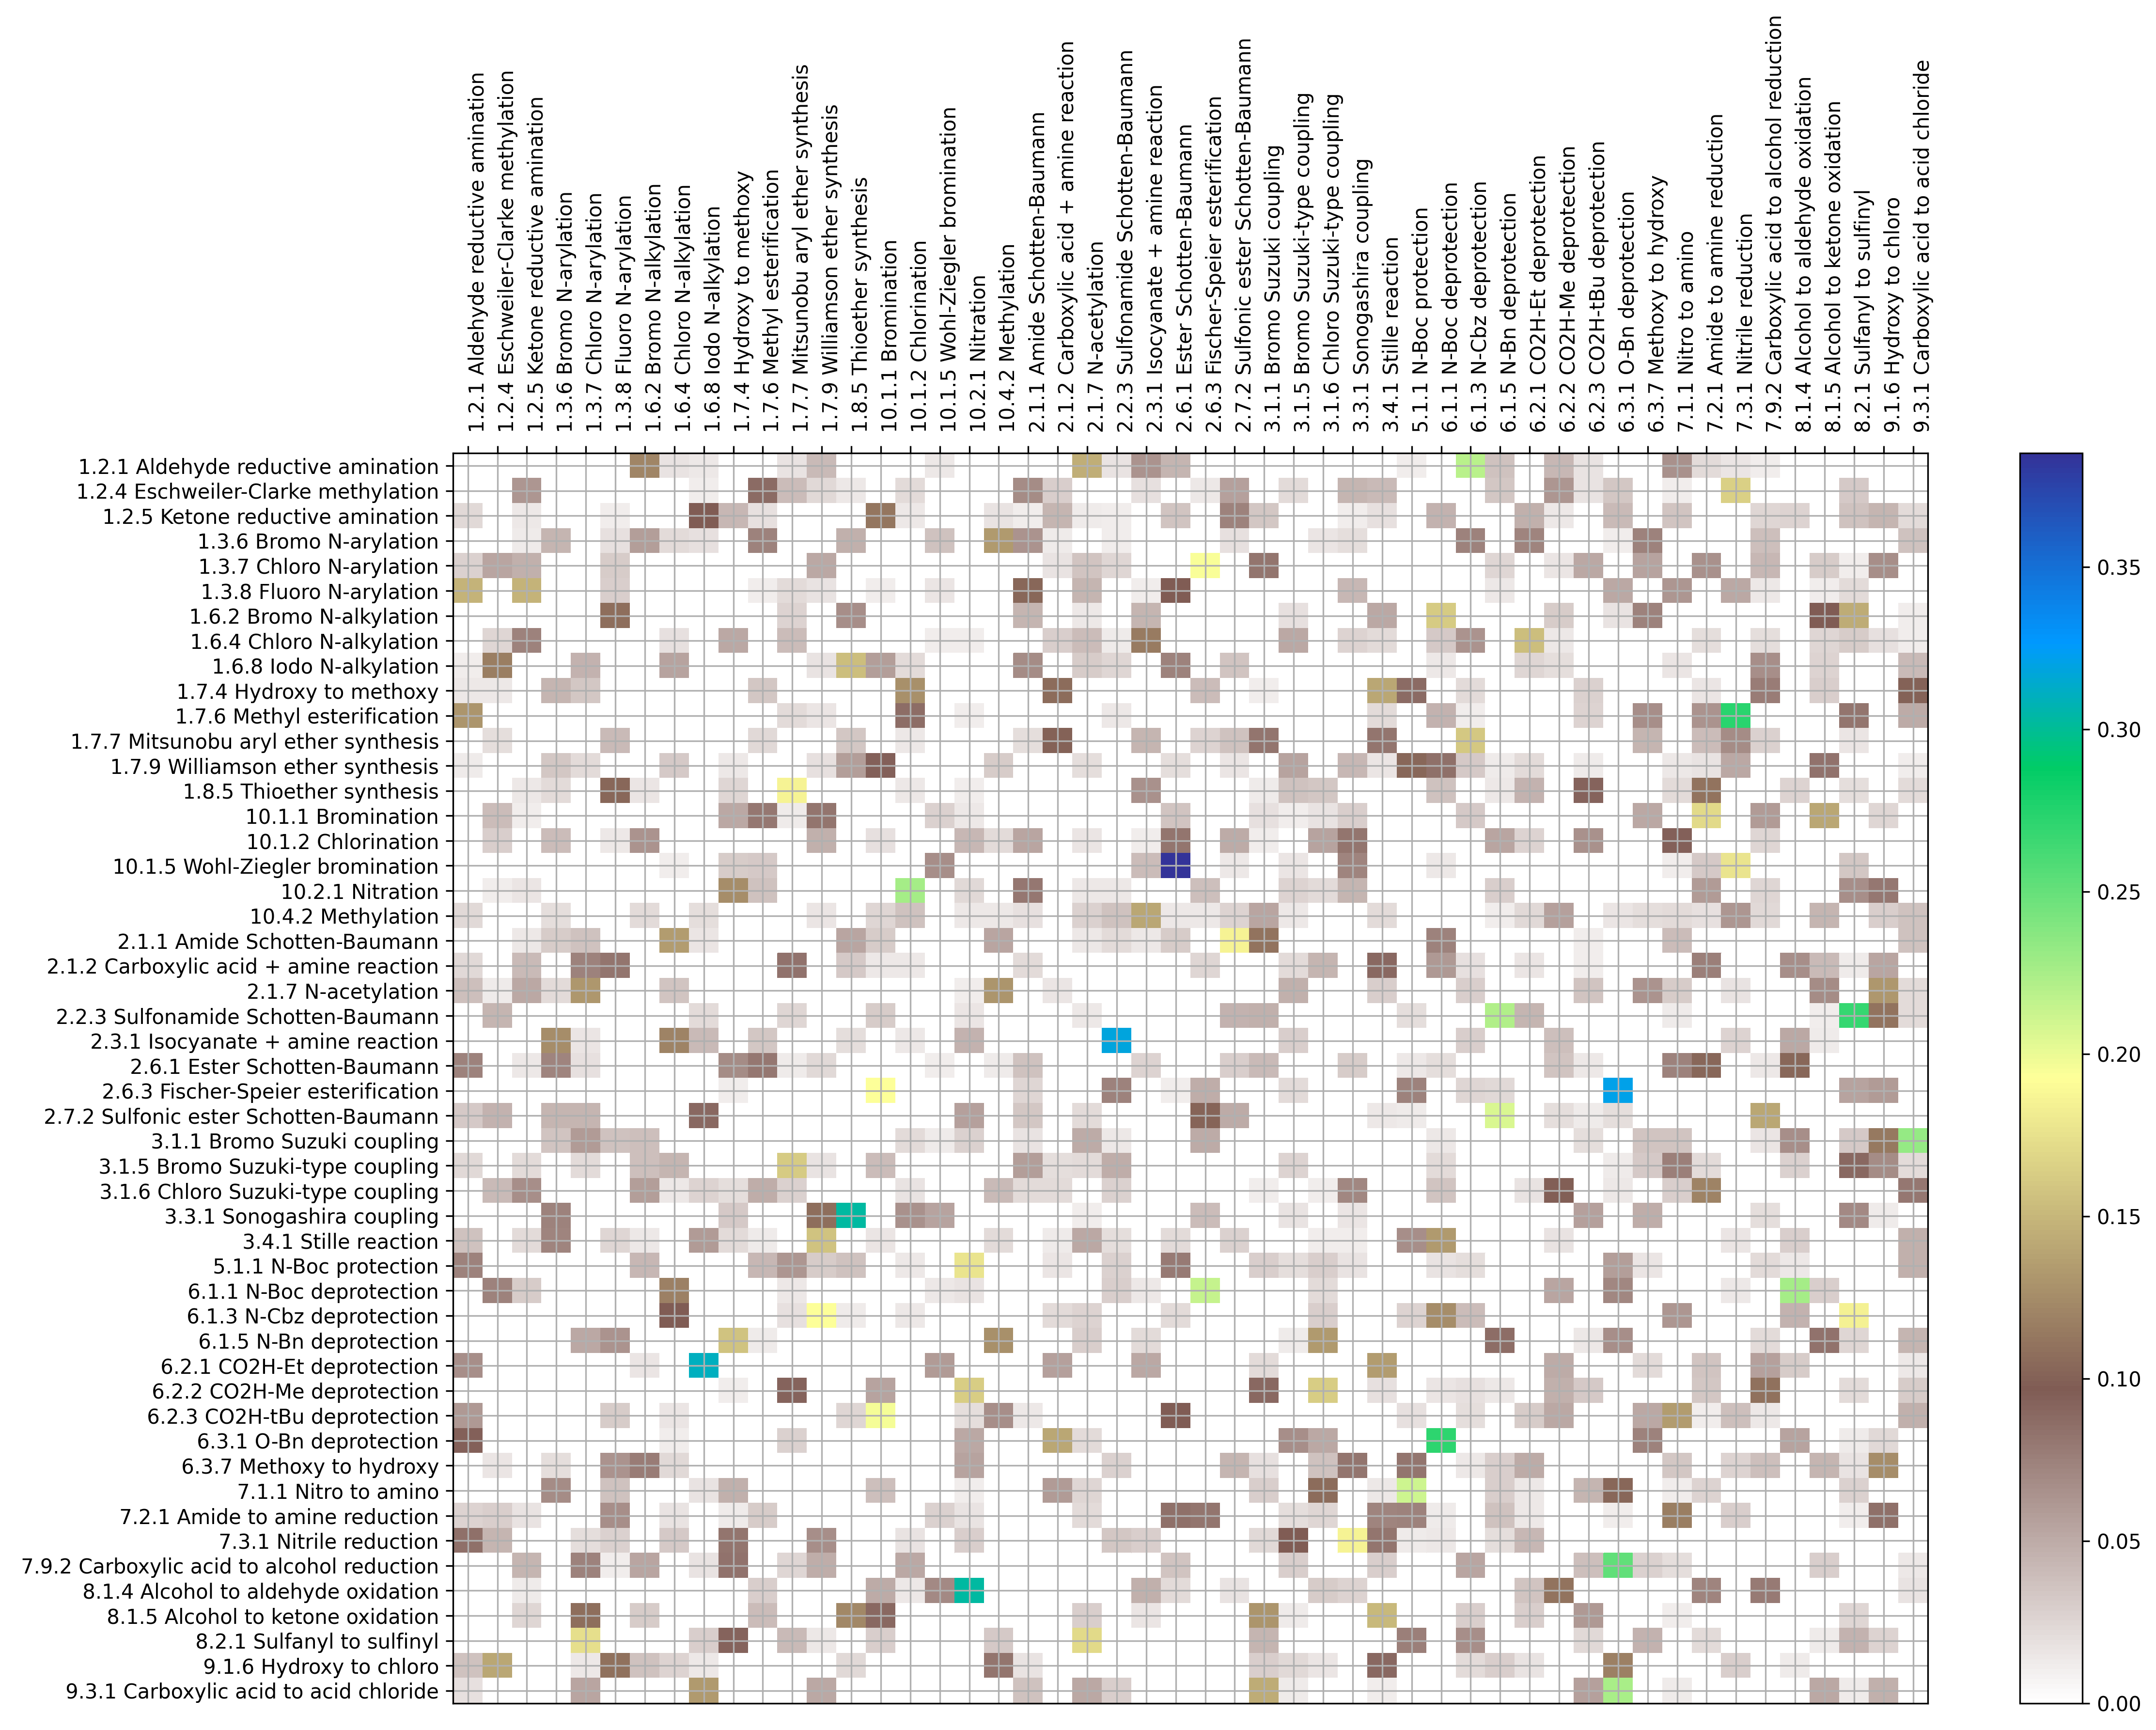

In [ ]:
# slow
lr_cls =  LogisticRegression(max_iter=1000)

scrambled_train_rxn_ids = [rxnclass2id[c] for c in train_df.rxn_class]
test_rxn_class_ids = [rxnclass2id[c] for c in test_df.rxn_class]


random.seed(42)
random.shuffle(scrambled_train_rxn_ids)
lr_classifier_scrambled = lr_cls.fit(train_df.ft_10k.values.tolist(), scrambled_train_rxn_ids)
confusion_matrix_scrambled = evaluate_model(lr_classifier_scrambled, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_scrambled, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)

With the randomized labels this is what we expected.

### Actual train and testing

Using the `[CLS] token embeddings` of a BERT model fine tuned on the 10k train reactions we get the following:

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.9988 & 0.9901 &0.9944 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.9712 & 0.9848 &0.9780 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9888 & 0.9950 &0.9918 & Ketone reductive amination &1.2.5 \\
 3 & 0.9912 & 0.9863 &0.9888 & Bromo N-arylation &1.3.6 \\
 4 & 0.9962 & 0.9827 &0.9894 & Chloro N-arylation &1.3.7 \\
 5 & 0.9975 & 0.9876 &0.9925 & Fluoro N-arylation &1.3.8 \\
 6 & 0.9825 & 0.9788 &0.9807 & Bromo N-alkylation &1.6.2 \\
 7 & 0.9437 & 0.9921 &0.9673 & Chloro N-alkylation &1.6.4 \\
 8 & 0.9838 & 0.9825 &0.9831 & Iodo N-alkylation &1.6.8 \\
 9 & 0.9775 & 0.9678 &0.9726 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9838 & 0.9838 &0.9838 & Methyl esterification &1.7.6 \\
11 & 0.9675 & 0.9639 &0.9657 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.9750 & 0.9665 &0.9708 & Williamson ether synthesis &1.7.9 \\
13 & 0.9938 & 0.9938 &0.9938 & Thioether synthesis &1.8.5 \\
14 & 0.9575 & 0.9935 &0.9752 & Bromination &10.1.1 \\


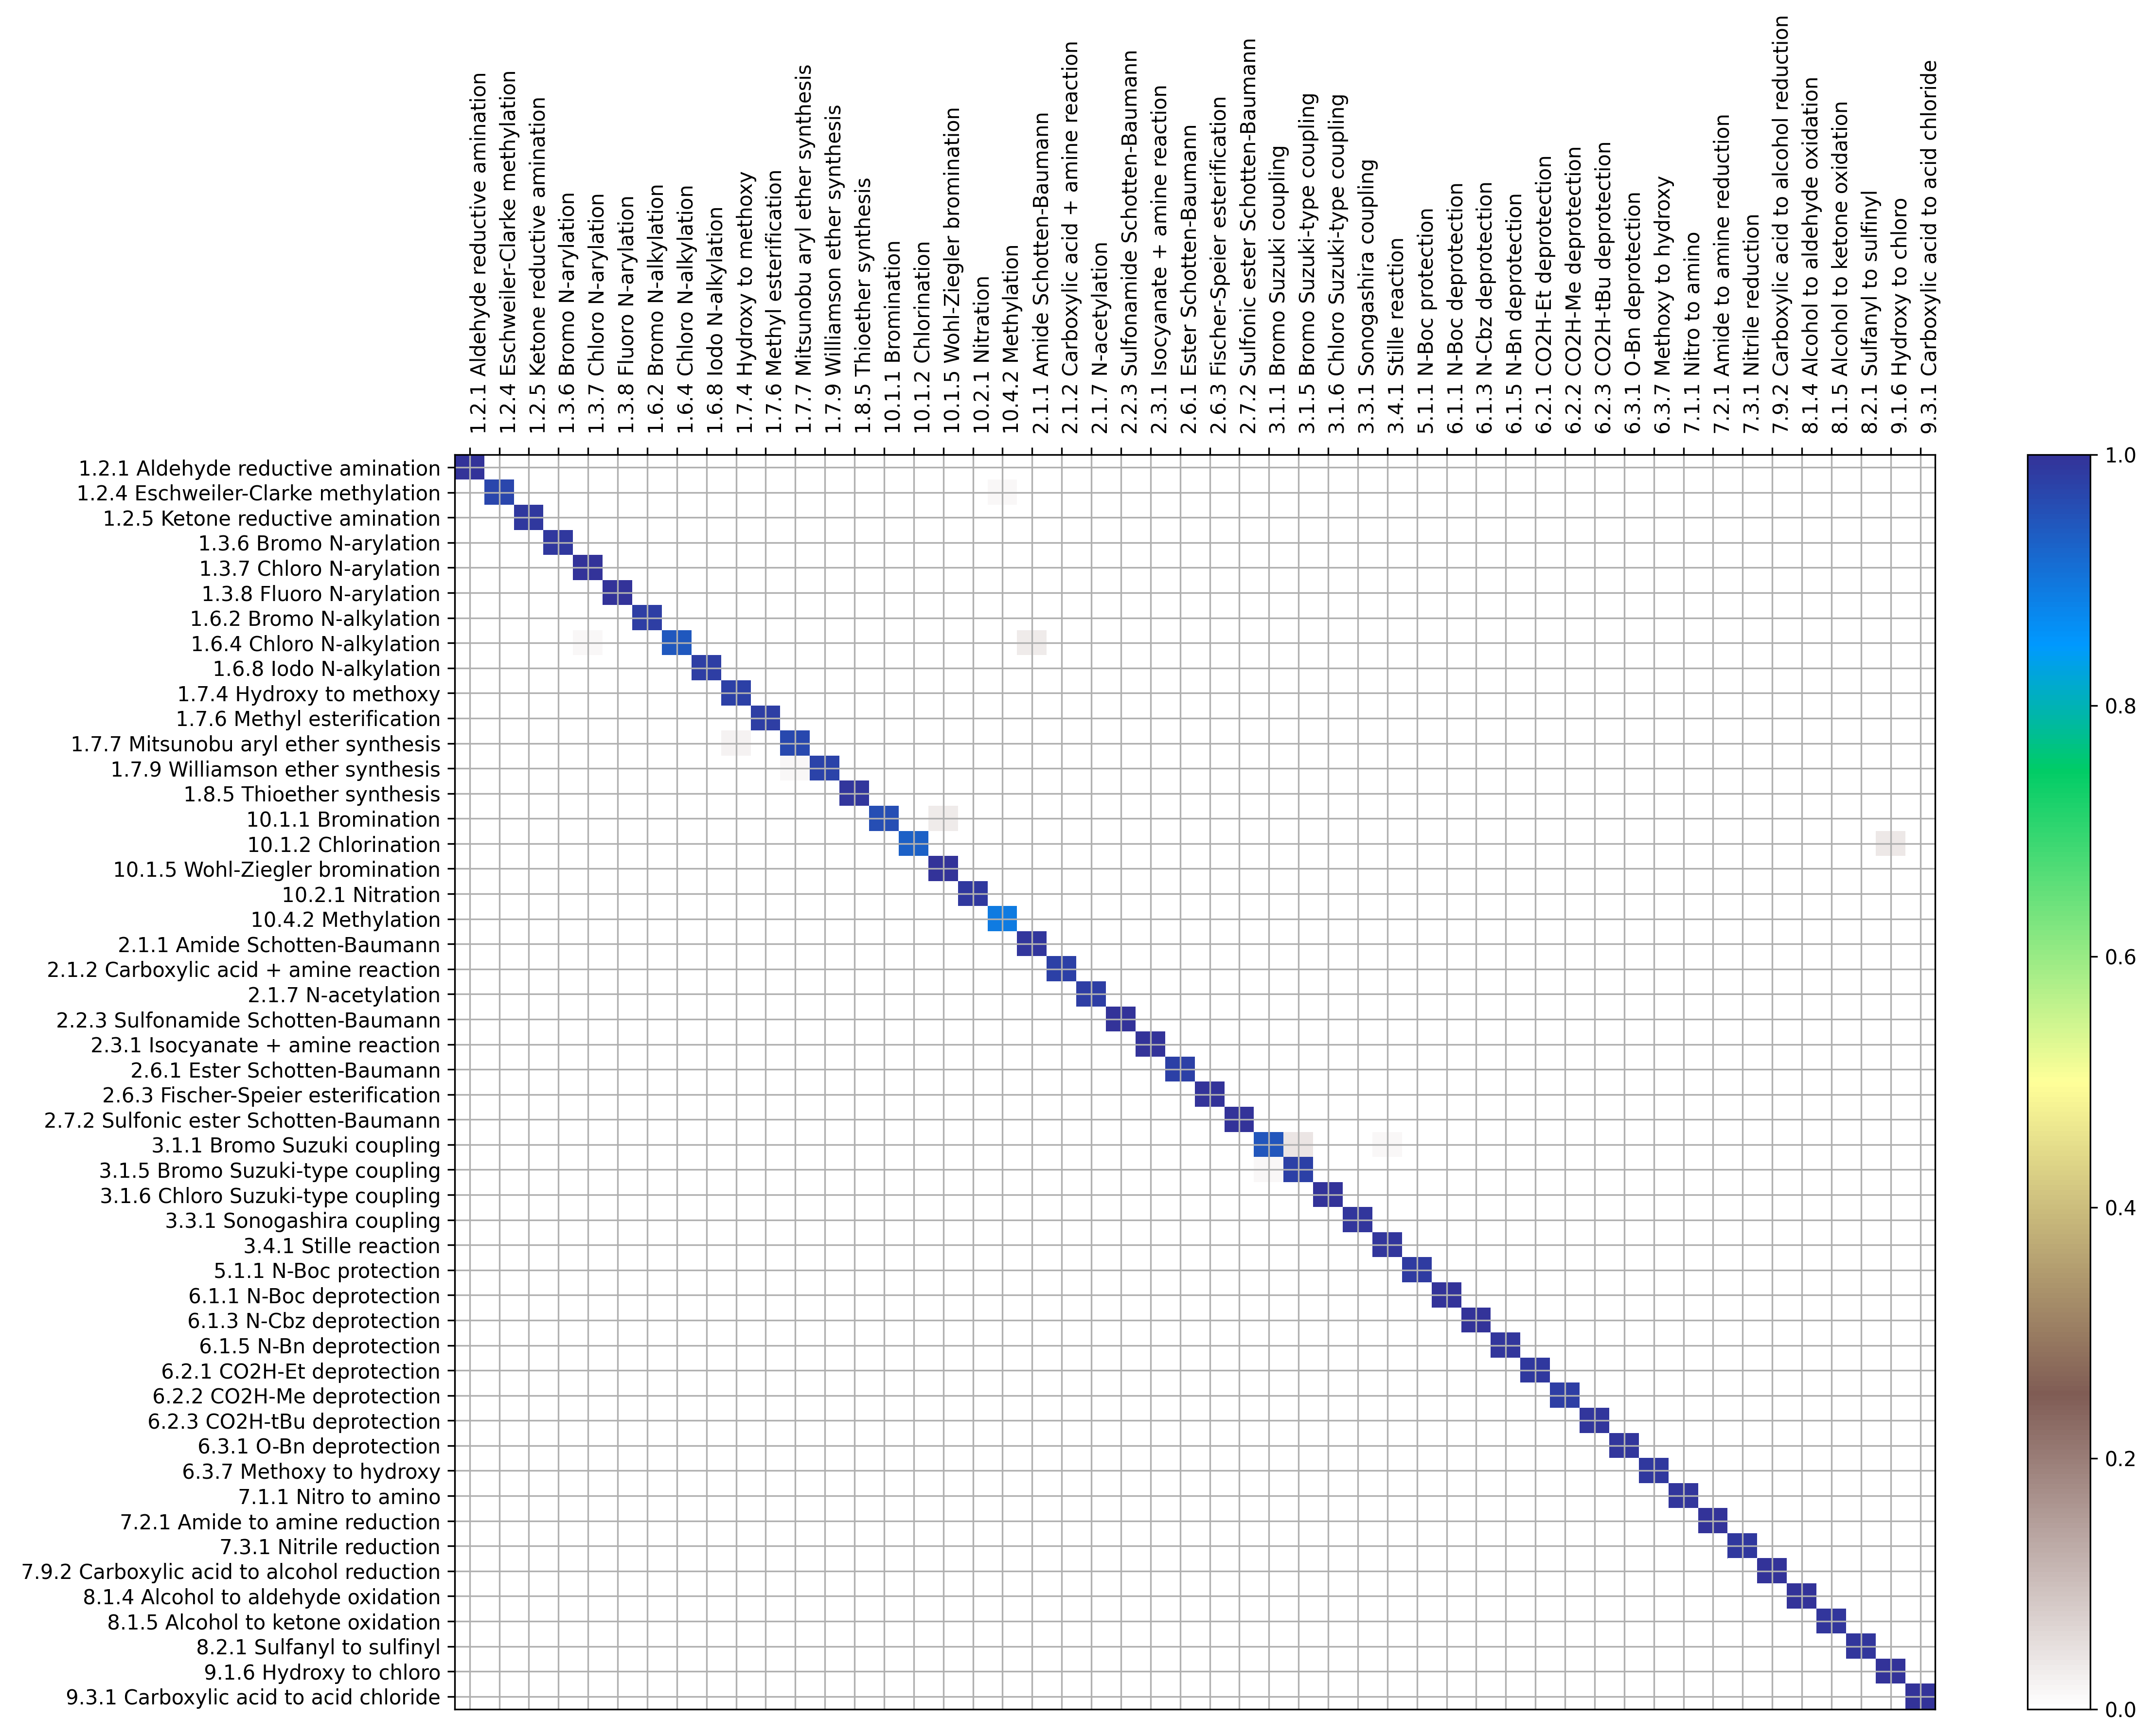

In [ ]:
# slow
lr_cls =  LogisticRegression(max_iter=5000)
lr_classifier_ft_10k_trained = lr_cls.fit(train_df.ft_10k.values.tolist(), train_df.class_id.values.tolist())
confusion_matrix_ft_10k = evaluate_model(lr_classifier_ft_10k_trained, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_ft_10k, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)
#fig.savefig('cm_ft_10k.pdf')

## RXNFP pretrained 
This reaction fingerprint was only pretrained on a large set of reaction SMILES

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.9012 & 0.8968 &0.8990 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.8075 & 0.8325 &0.8198 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9213 & 0.9224 &0.9218 & Ketone reductive amination &1.2.5 \\
 3 & 0.8600 & 0.8643 &0.8622 & Bromo N-arylation &1.3.6 \\
 4 & 0.8725 & 0.7950 &0.8319 & Chloro N-arylation &1.3.7 \\
 5 & 0.9200 & 0.9497 &0.9346 & Fluoro N-arylation &1.3.8 \\
 6 & 0.8113 & 0.8342 &0.8226 & Bromo N-alkylation &1.6.2 \\
 7 & 0.7600 & 0.7696 &0.7648 & Chloro N-alkylation &1.6.4 \\
 8 & 0.8125 & 0.7908 &0.8015 & Iodo N-alkylation &1.6.8 \\
 9 & 0.8500 & 0.8673 &0.8586 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9200 & 0.9258 &0.9229 & Methyl esterification &1.7.6 \\
11 & 0.8387 & 0.8515 &0.8451 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.8000 & 0.7960 &0.7980 & Williamson ether synthesis &1.7.9 \\
13 & 0.9213 & 0.8880 &0.9043 & Thioether synthesis &1.8.5 \\
14 & 0.9437 & 0.9461 &0.9449 & Bromination &10.1.1 \\


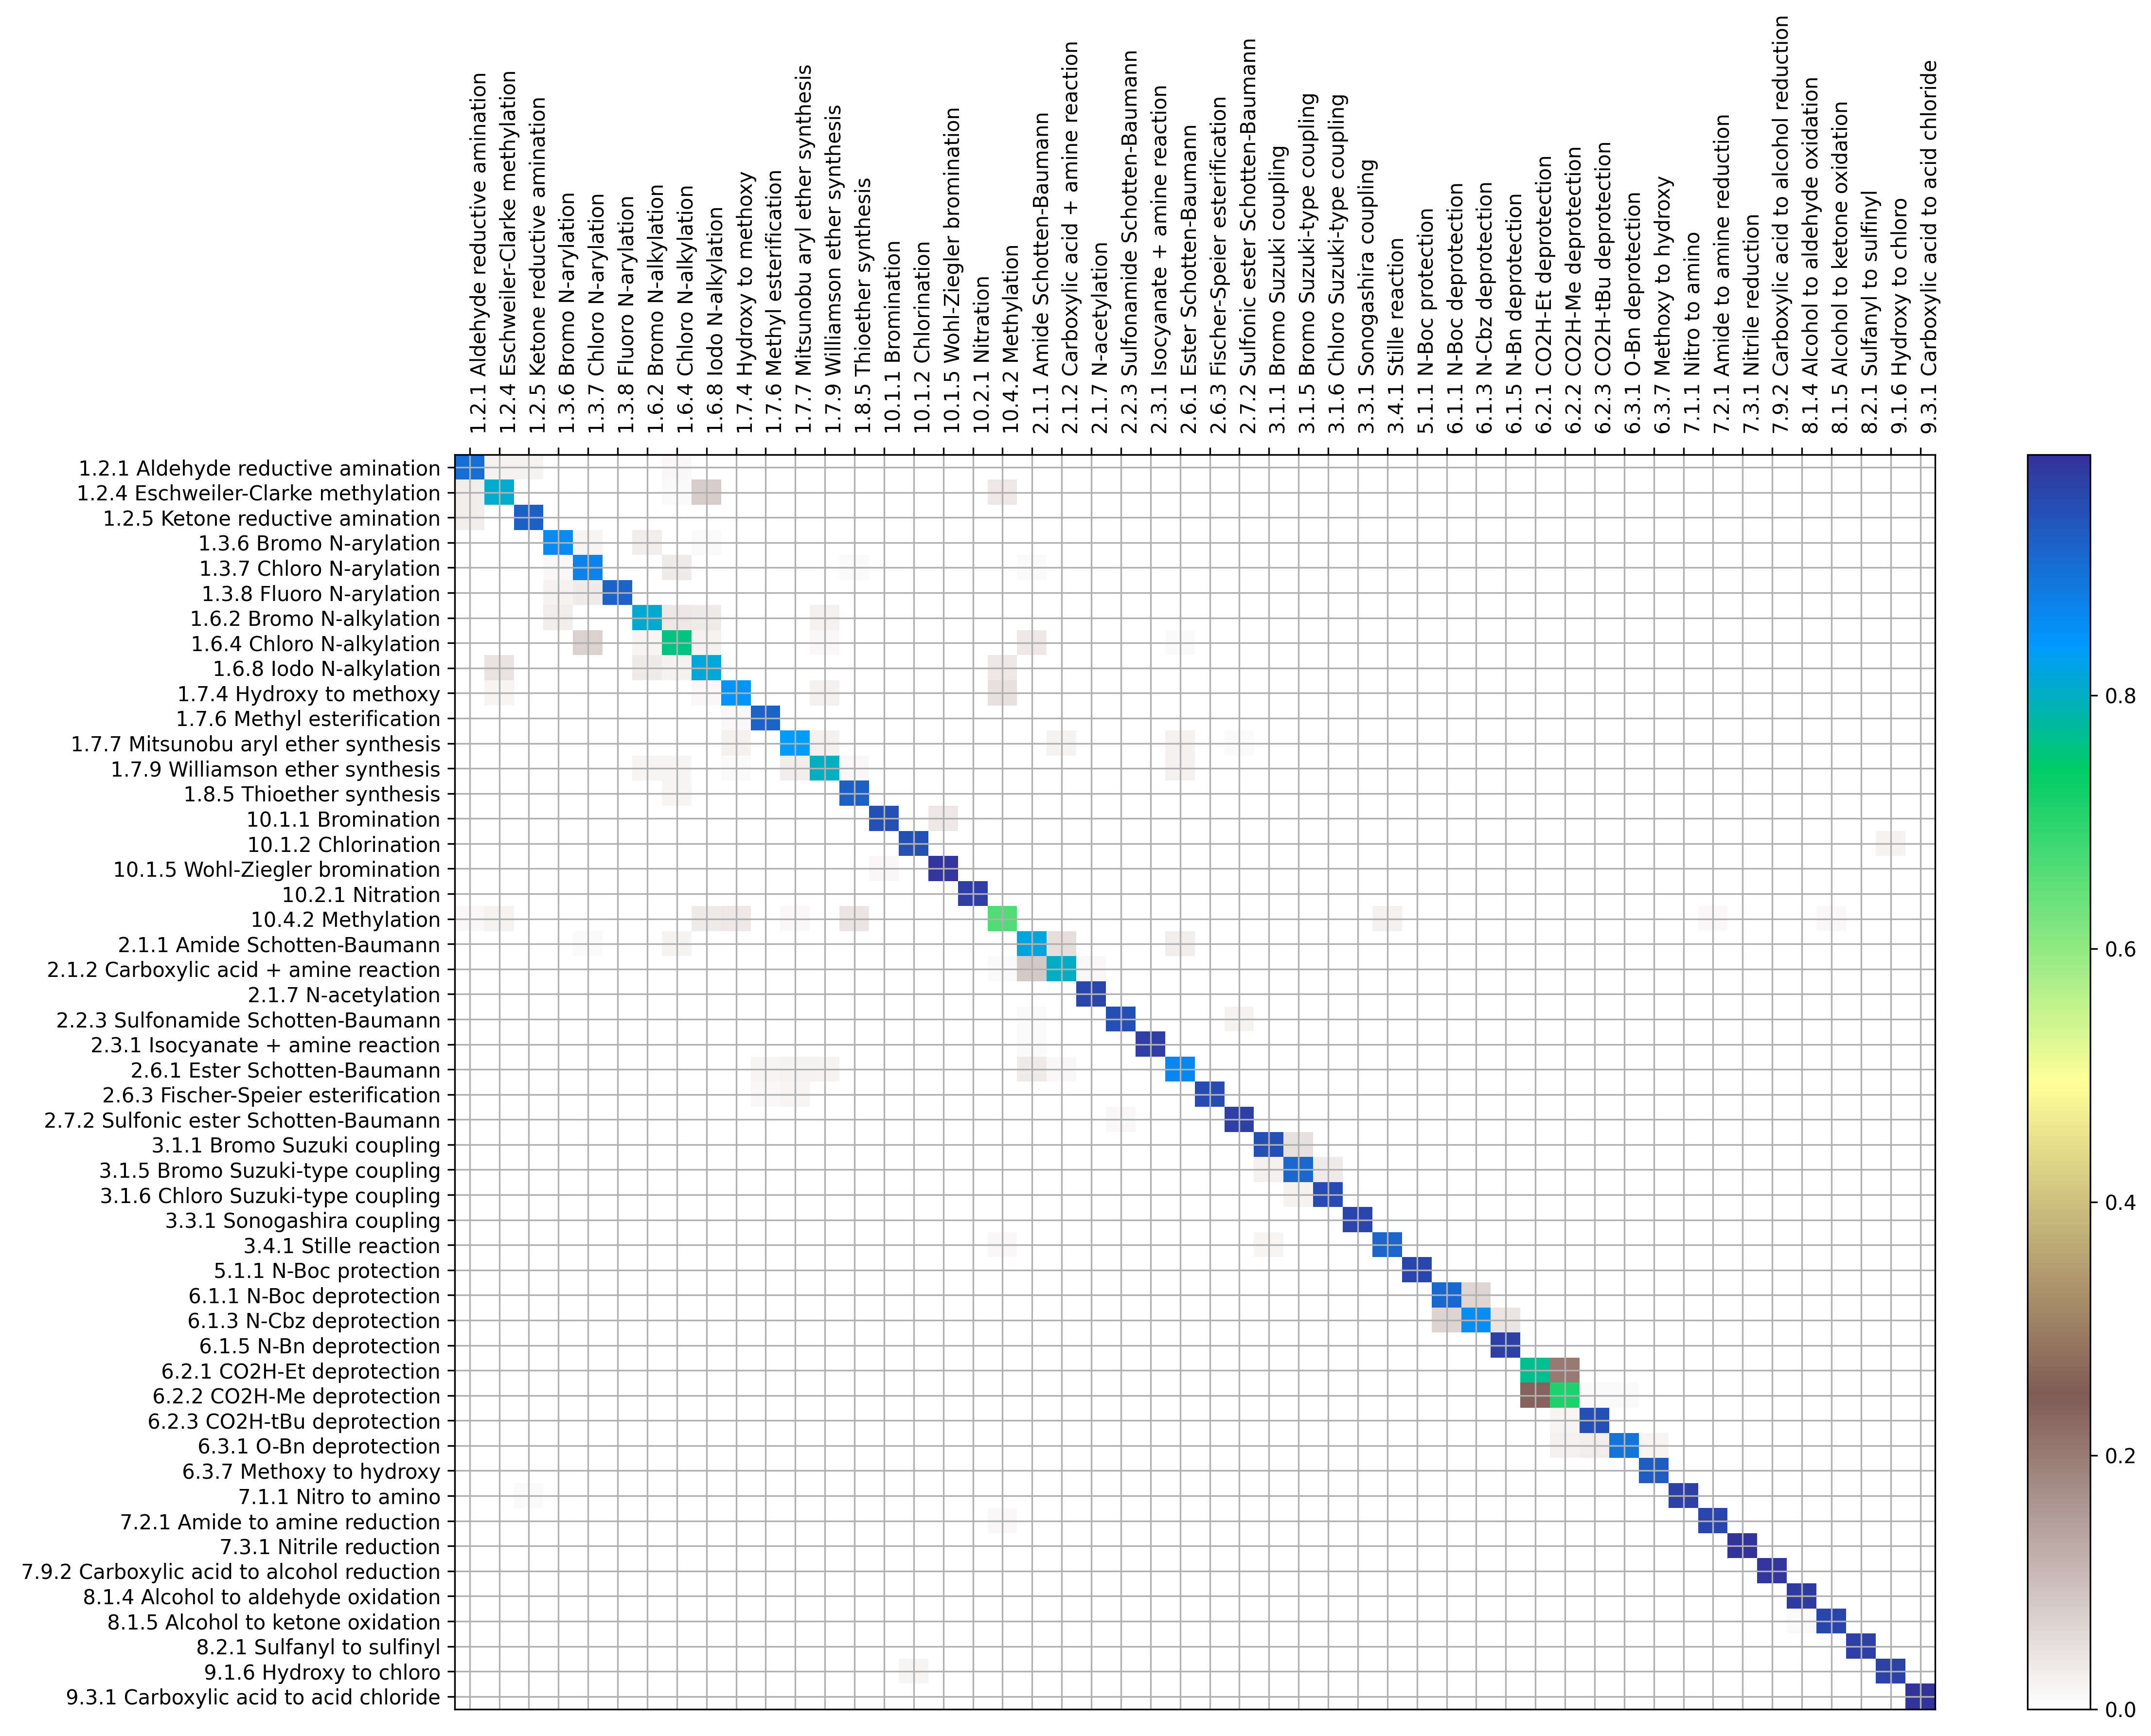

In [ ]:
# slow
lr_cls =  LogisticRegression(max_iter=5000)
lr_classifier_ft_pretrained = lr_cls.fit(train_df.ft_pretrained.values.tolist(), train_df.class_id.values.tolist())
confusion_matrix_pretrained = evaluate_model(lr_classifier_ft_pretrained, test_df.ft_pretrained.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_pretrained, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)
#fig.savefig('cm_ft_pretrained.pdf')

## Pretrained classifier predicting on fine-tuned fingerprints 
This is another experiment that shows that for some of the classes the pretrained fingerprint contained already most of the information and the fine-tuning did not change how the BERT model would embed the class token.

 & recall & prec & F-score  &   reaction class &  \\ 
 0 & 0.2525 & 1.0000 &0.4032 & Aldehyde reductive amination &1.2.1 \\
 1 & 0.9437 & 0.9908 &0.9667 & Eschweiler-Clarke methylation &1.2.4 \\
 2 & 0.9925 & 0.9950 &0.9937 & Ketone reductive amination &1.2.5 \\
 3 & 0.0000 & 0.0000 &0.0000 & Bromo N-arylation &1.3.6 \\
 4 & 0.0000 & 0.0000 &0.0000 & Chloro N-arylation &1.3.7 \\
 5 & 0.1725 & 1.0000 &0.2942 & Fluoro N-arylation &1.3.8 \\
 6 & 0.0000 & 0.0000 &0.0000 & Bromo N-alkylation &1.6.2 \\
 7 & 0.0350 & 0.0545 &0.0426 & Chloro N-alkylation &1.6.4 \\
 8 & 0.0000 & 0.0000 &0.0000 & Iodo N-alkylation &1.6.8 \\
 9 & 0.0000 & 0.0000 &0.0000 & Hydroxy to methoxy &1.7.4 \\
10 & 0.9875 & 0.4345 &0.6035 & Methyl esterification &1.7.6 \\
11 & 0.9400 & 0.2258 &0.3642 & Mitsunobu aryl ether synthesis &1.7.7 \\
12 & 0.8387 & 0.9319 &0.8829 & Williamson ether synthesis &1.7.9 \\
13 & 0.9850 & 0.9937 &0.9893 & Thioether synthesis &1.8.5 \\
14 & 0.9862 & 0.4405 &0.6090 & Bromination &10.1.1 \\


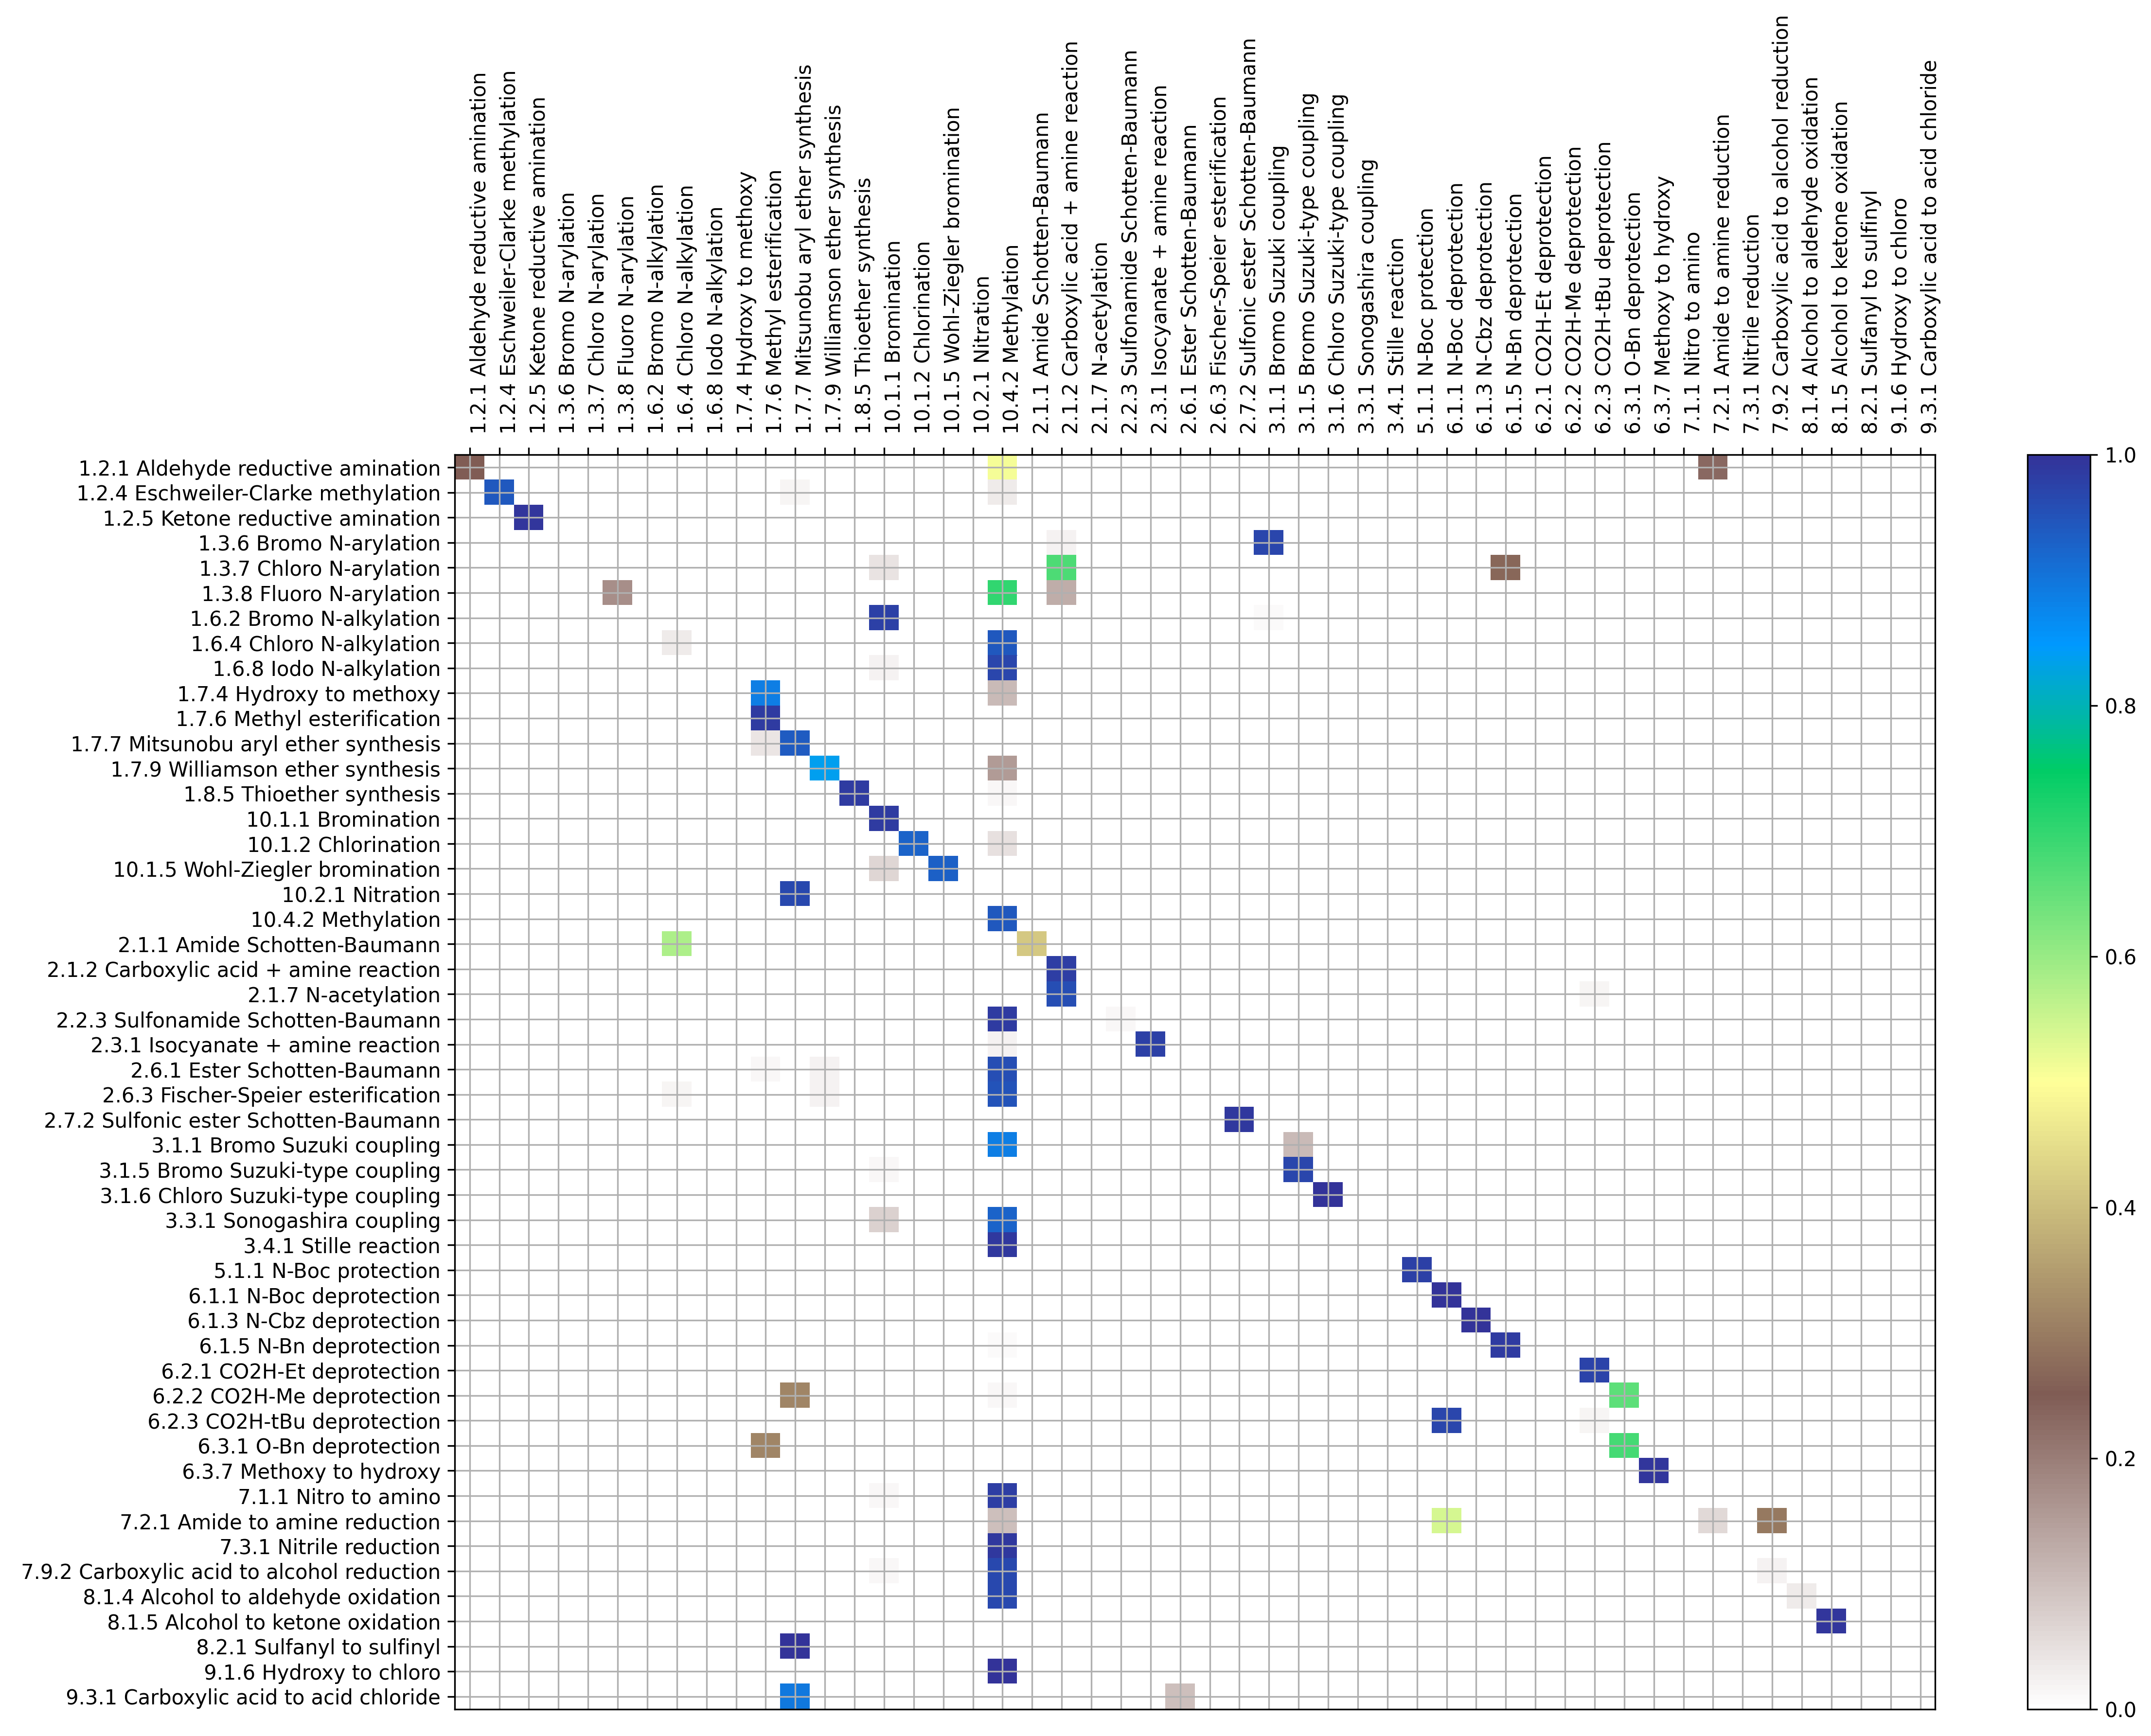

In [ ]:
# slow
confusion_matrix_pretrained = evaluate_model(lr_classifier_ft_pretrained, test_df.ft_10k.values.tolist(), test_rxn_class_ids, all_classes, rxnclass2name)
fig = labelled_cmat(confusion_matrix_pretrained, 
                    all_classes,
                    figsize=(16,12), label_extras=rxnclass2name)
#fig.savefig('cm_ft_pretrained_on_ft_10k.pdf')